# Drake Systems Fundamentals

**Learning Objectives:**
1. Implement a custom `LeafSystem` from scratch
2. Understand Drake's block diagram systems framework
3. Build and wire block diagrams yourself
4. Write simulation code
5. Use Drake documentation and tutorials effectively

**What you'll implement:** You'll implement an inverted pendulum system from scratch, and simulate it using Drake's built-in simulation tools.

---


## Setup and Imports

Let us first import Drake functionality. We will cover them as we go along, so don't worry about them for now. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pydrake.all import (
    BasicVector,
    ConstantVectorSource,
    Context,
    ContinuousState,
    Diagram,
    DiagramBuilder,
    LeafSystem,
    LogVectorOutput,
    Simulator,
)
from pydrake.systems.drawing import plot_system_graphviz

from manipulation.exercises.grader import Grader
from manipulation.exercises.intro.test_intro_fundamentals import (
    TestIntroFundamentalsPendulumImplementation,
    TestIntroFundamentalsSimulationExercises,
)

---

## Part 1: Writing Your Own Dynamics

Drake models complex systems as **block diagrams** composed of simple building blocks. Each block is a `System` that:
- Has **input ports** (receives signals)
- Has **output ports** (sends signals) 
- Maintains internal **state**
- Defines **dynamics** (how state evolves over time)

A `System` can be just a simple, single system, or it can be a collection of multiple smaller subsystems, for instance connected together in a `Diagram` (which we will learn more about in a second). For now, we will look only at a single custom system, which you will usually implement by inheriting from the Drake class `LeafSystem`. In this part of the notebook, you will implement your own simple physical system (an inverted pendulum) using `LeafSystem`. Later in the class and for the project you might find yourself inheriting from `LeafSystem` when you are writing custom controllers, estimators, sensors, etc!

Below you can see an example of a `Diagram` consisting of smaller subsystems: an inverted pendulum with a constant input source, which outputs to a logging system. In fact, this is the `Diagram` we will be building from scratch in this notebook!

<img src="https://raw.githubusercontent.com/RussTedrake/manipulation/refs/heads/master/book/figures/simple_inverted_pendulum_diagram.svg" width="1000">

**References:** To implement the tasks in this notebook, you will be referencing the official Drake tutorials. You don't have to read everything in them right now, we provide hints in the code pointing you towards the relevant sections. The tutorials we will be referencing are:
- [Dynamical Systems Tutorial](https://github.com/RobotLocomotion/drake/blob/master/tutorials/dynamical_systems.ipynb)
- [Authoring Leaf Systmes](https://github.com/RobotLocomotion/drake/blob/7abd7dc1a95387490e2d5fa23fe938f57eddecfc/tutorials/authoring_leaf_systems.ipynb)

If you are unsure about how to use a function, refer to the [Official Drake documentation](https://drake.mit.edu/pydrake/index.html). For example, the documentation for `DeclareVectorInputPort` and similar functions can be found [on this page](https://drake.mit.edu/pydrake/pydrake.systems.framework.html) which we found by searching for "DeclareVectorInputPort) and then by cmd+F for "DeclareVectorInputPort". 

(**A note on the Drake documentation:** There are two sets of documentation for Drake: one for Python and [one for C++](https://drake.mit.edu/doxygen_cxx/index.html). The C++ and Python APIs for Drake are the same, but the C++ documentation is usually a bit more detailed and easier to navigate than the Python documentation, so most users of Drake tend to prefer the C++ documentation. So as you get more familiar with Drake, you might want to check out the C++ documentation instead!)

**YOUR TASK:** Implement an inverted pendulum (with zero friction) as a custom `LeafSystem`
Here are the system specifications you will need:
- **State:** $x = [\theta, \dot{\theta}]$ (angle and angular velocity)
- **Input:** $u$ (torque applied at the base)  
- **Dynamics:** $\ddot{\theta} = -\frac{g}{l}\sin(\theta) + \frac{u}{ml^2}$
- **Output:** $y = \theta$ (just the angle)

In [ ]:
# TODO: Implement your own InvertedPendulum class


class InvertedPendulum(LeafSystem):
    def __init__(
        self, mass: float = 1.0, length: float = 1.0, gravity: float = 9.81
    ) -> None:
        # HINT: Look at the Dynamical Systems Tutorial,
        #       section "Deriving from LeafSystem"
        # TODO: Call the parent constructor
        LeafSystem.__init__(self) 

        # TODO: Store the physical parameters as instance variables
        self.mass = mass 
        self.length = length 
        self.gravity = gravity

        # TODO: Declare continuous state for [theta, theta_dot]
        #       (note that we won't need the state_index they use in the tutorial,
        #        so you can disregard the return value)

        self.DeclareContinuousState(2)
        
        # HINT: Look at the Authoring Leaf Systems Tutorial,
        #       section "Vector-valued Ports"
        # TODO: Declare input port for torque
         # TODO: Save the input port as an instance variable so we can
        #       access it in `DoCalcTimeDerivatives`
        self._torque_input_port =  self.DeclareVectorInputPort("torque", 1)


        # TODO: Declare output port for **just** theta (not theta_dot)
        self.DeclareVectorOutputPort("theta", 1, self.OutputTheta)
 
    def DoCalcTimeDerivatives(
        self, context: Context, derivatives: ContinuousState
    ) -> None:
        # HINT: Look at the Dynamical Systems Tutorial,
        #       section "Deriving from LeafSystem"
        # TODO: Get current state from context (extract theta and theta_dot)
        # HINT: Note that context.get_continuous_state_vector() returns a VectorBase
        #       object, which you can index into to get the theta and theta_dot using
        #       .GetAtIndex(), or simply context.get_continuous_state_vector()[index]
        #       or simply context.get_continuous_state_vector()[index]

        curr_theta = context.get_continuous_state_vector().GetAtIndex(0)
        curr_theta_dot = context.get_continuous_state_vector().GetAtIndex(1)
        # HINT: Look at the Authoring Leaf Systems Tutorial,
        #       section "Vector-valued Ports"
        # TODO: Get input torque by evaluating the input port

        input_torque = self._torque_input_port.Eval(context)[0]

        # HINT: Look at the Dynamical Systems Tutorial,
        #       section "Deriving from LeafSystem"
        # TODO: Compute pendulum dynamics
        # TODO: Set the derivatives [theta_dot, theta_ddot]
        theta_ddot = -1 * (self.gravity / self.length) * np.sin(curr_theta) + (input_torque / (self.mass * (self.length ** 2)))
        derivatives.get_mutable_vector().SetAtIndex(0, curr_theta_dot)
        derivatives.get_mutable_vector().SetAtIndex(1, theta_ddot)

    def OutputTheta(self, context: Context, output: BasicVector) -> None:
        # HINT: Look at the Authoring Leaf Systems Tutorial,
        #       section "Vector-valued Ports"
        # TODO: Get state from context, and extract theta (first element)
        first_element = context.get_continuous_state_vector().GetAtIndex(0) 
        # TODO: Set the output port to theta
        output.SetFromVector([first_element])

 

**When you are done, make sure to run the tests below to make sure everything is working as expected!**

In [15]:
Grader.grade_output(
    [TestIntroFundamentalsPendulumImplementation], [locals()], "results.json"
)
Grader.print_test_results("results.json")

Total score is 30/30.

Score for test_inverted_pendulum_structure (manipulation.exercises.intro.test_intro_fundamentals.TestIntroFundamentalsPendulumImplementation) is 10/10.

Score for test_pendulum_dynamics (manipulation.exercises.intro.test_intro_fundamentals.TestIntroFundamentalsPendulumImplementation) is 10/10.

Score for Test pendulum output computation is 10/10.


### System `Context`
In the code above, you probably noticed the use of something called the `context`. In Drake, the `context` contains all the dynamical information about your simulation and all the systems in it.

Please read the following tutorial section before proceeding:
- [Dynamical Systems Tutorial](https://github.com/RobotLocomotion/drake/blob/master/tutorials/dynamical_systems.ipynb): **The System "Context"**

Next, let us create a default context for our Pendulum, change it a bit, and have a look at it!

For this simple system, you see that the context only contains the current time, as well as the two states we defined for our system.

In [16]:
# TODO: Set the values for time and state to some reasonable values
time = 0.1
theta = 0.1
theta_dot = 0.1

# TODO: Uncomment the following lines:
pendulum = InvertedPendulum()
pendulum_context = pendulum.CreateDefaultContext()
pendulum_context.get_mutable_continuous_state().SetFromVector([theta, theta_dot])
pendulum_context.SetTime(time)
print(pendulum_context)

::_ Context
------------
Time: 0.1
States:
  2 continuous states
    0.1 0.1




--- 
## Part 2: Connecting Systems in a Diagram

In this part, you will create a complete `Diagram` that we will later use for simulation by connecting multiple Drake `System`s together:
1. **InvertedPendulum** - your dynamical system
2. **ConstantVectorSource** - provides constant torque input  
3. **LogVectorOutput** - records output data over time

**YOUR TASK:** Build a `Diagram` for simulation of the inverted pendulum, where the pendulum is provided with a constant input torque, and we log the outputs.

**References:** In this part, we will only be referencing this tutorial (we will keep pointing you towards the relevant sections in the code):
- [Dynamical Systems Tutorial](https://github.com/RobotLocomotion/drake/blob/master/tutorials/dynamical_systems.ipynb): section **"Simulation"** and **"Combinations of Systems: Diagram and DiagramBuilder"**

In [32]:
# TODO: Implement the diagram builder function


def build_pendulum_diagram(
    input_torque: float = 0.0,
) -> tuple[Diagram, InvertedPendulum, LogVectorOutput]:

    # HINT: Look at the Dynamical Systems Tutorial, section "Simulation"
    # TODO: Create a DiagramBuilder
    builder = DiagramBuilder()

    # TODO: Add your inverted pendulum system to the builder
    pendulum_sys = builder.AddSystem (InvertedPendulum())
    pendulum_sys.set_name("pendulum_system")
    # TODO: Add a constant torque source
    # HINT: This is not in the tutorial, so we have provided the code for you.
    torque_source = ConstantVectorSource(np.array([input_torque]))
    torque_source_sys = builder.AddSystem(torque_source)
    torque_source_sys.set_name("constant source system")

    # TODO: Add data logging system
    logger_system = LogVectorOutput(pendulum_sys.get_output_port(0), builder)
    logger_system.set_name("logger")

    # TODO: Connect the systems together
    # HINT: Look at the Dynamical Systems Tutorial, section
    #       "Combinations of Systems: Diagram and DiagramBuilder"
    # HINT: The constant torque source should be connected to the pendulum's input port,
    #       but the LogVectorOutput is already connected to the pendulum's output port.

    builder.Connect(torque_source.get_output_port(0), pendulum_sys.get_input_port(0))
    # TODO: Build and return the final diagram, system, and logger
    Diagram = builder.Build()
    Diagram.set_name("demo 1 diagram")

    return Diagram, pendulum_sys,  logger_system
    

# TODO: Uncomment the following line:
diagram, pendulum, logger = build_pendulum_diagram(input_torque=0.1)

**Next, we will visualize the block diagram.**

Drake can automatically generate graphical representations of your block diagrams, which can be very helpful for understanding the system connections and debug wiring issues.

Run the code below to visualize your diagram:

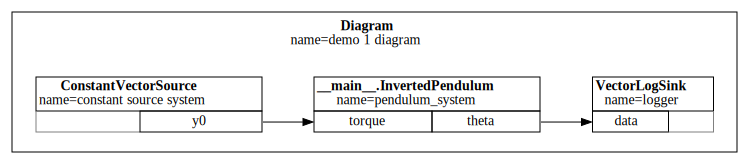

In [33]:
diagram, pendulum, logger = build_pendulum_diagram(input_torque=0.1)
diagram, pendulum, logger = build_pendulum_diagram(input_torque=0.1)
plot_system_graphviz(diagram)

After visualizing, make sure to have a look at the diagram. Are the connections and the number of ports as you would expect?

Let us also have a look at the Diagram context (notice how it includes the pendulum context from earlier!):

In [34]:
# TODO: Uncomment the following line:
diagram, pendulum, logger = build_pendulum_diagram(input_torque=0.1)

# TODO: Create a context for the diagram
diagram_context = diagram.CreateDefaultContext()
# TODO: Print the context for the diagram
print(diagram_context)

::demo 1 diagram Context (of a Diagram)
----------------------------------------
2 total continuous states
1 total numeric parameters in 1 groups

::demo 1 diagram::pendulum_system Context
------------------------------------------
Time: 0
States:
  2 continuous states
    0 0


::demo 1 diagram::constant source system Context
-------------------------------------------------
Time: 0
Parameters:
  1 numeric parameter groups with
     1 parameters
       0.1



**TIP:** This is not in the tutorial, but will be **very** useful soon in the class and for your project: 

If you ever want to get the context of a specific system from the entire diagram context, use the method:

`system.GetMyContextFromRoot(diagram_context)`.

Try it below for the inverted pendulum, and notice how we get back the simple pendulum context we printed earlier!


In [35]:
# TODO: Get the context of the pendulum from the diagram context
pendulum_default_context =  pendulum.GetMyContextFromRoot(diagram_context)
# TODO: Print the pendulum context
print(pendulum_default_context)

::demo 1 diagram::pendulum_system Context
------------------------------------------
Time: 0
States:
  2 continuous states
    0 0




## Part 3: Simulation
In this part, we will finally put everything together and run the full simulation of our pendulum.

**YOUR TASK:** Implement the full simulation for your inverted pendulum system.

**References:** In this part, we will only be referencing this tutorial (we will keep pointing you towards the relevant sections in the code):
- [Dynamical Systems Tutorial](https://github.com/RobotLocomotion/drake/blob/master/tutorials/dynamical_systems.ipynb): section **"Simulation"**

In [36]:
# TODO: Implement the simulation function


def simulate_pendulum(
    initial_state: np.ndarray, simulation_time: float = 5.0, torque: float = 0.0
) -> tuple[np.ndarray, np.ndarray]:
    # TODO: Build your diagram using the function you implemented
    diagram, pendulum, logger = build_pendulum_diagram(input_torque=torque)

    # HINT: Look at the Dynamical Systems Tutorial, section "Simulation"
    # TODO: Create a context for the diagram
    diagram_context = diagram.CreateDefaultContext()

    # TODO: Create a simulator for the diagram with the context
    simulator = Simulator(diagram, diagram_context)

    # TODO: Set initial conditions for the pendulum
    pendulum_context = pendulum.GetMyMutableContextFromRoot(diagram_context)
    pendulum_init_state = pendulum_context.get_mutable_continuous_state_vector()
    pendulum_init_state.SetFromVector(initial_state)
     

    # TODO: Run the simulation to the specified time
    simulator.Initialize()
    simulator.AdvanceTo(simulation_time)
    # TODO: Extract the logged data from the logger
    log = logger.FindLog(diagram_context)
    # TODO: Return the time and state data from the log
    time_data = log.sample_times()
    theta_data = log.data()
    

    return time_data, theta_data
 

When you are done, let us run the code below to test the implementation. We will check that the pendulum swings past the downright equilibrium point, and also do some visualization so you can see what is happening!

Simulation complete! Recorded 407 timesteps
Initial angle: 0.5000 rad (28.6°)
Final angle: 0.4177 rad (23.9°)
✅ Physics check PASSED - pendulum oscillated as expected
Let us plot the angle over time (notice how there is no friction, hence the pendulum swings indefinitely!):


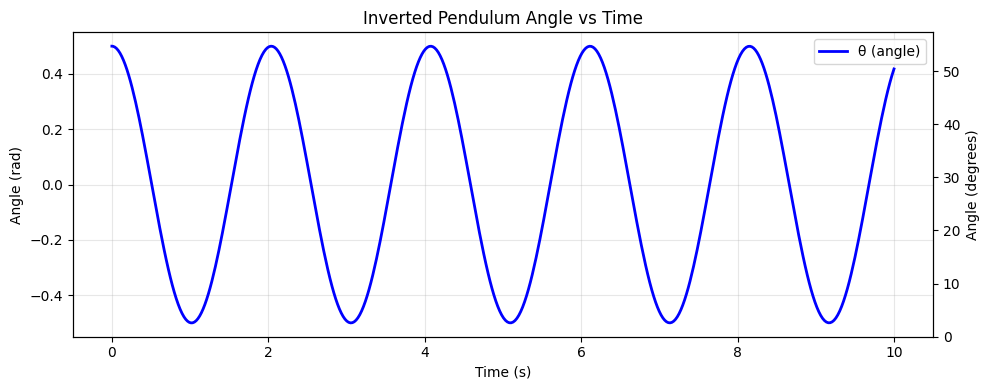

In [37]:
# Test your implementation (you do not need to modify this code)
initial_state = [0.5, 0.0]  # small angle, zero velocity
times, outputs = simulate_pendulum(initial_state, simulation_time=10.0, torque=0.0)

print(f"Simulation complete! Recorded {len(times)} timesteps")
print(f"Initial angle: {outputs[0, 0]:.4f} rad ({np.degrees(outputs[0, 0]):.1f}°)")
print(f"Final angle: {outputs[0, -1]:.4f} rad ({np.degrees(outputs[0, -1]):.1f}°)")

# Check if pendulum swung past the equilibrium point
min_angle = np.min(np.abs(outputs[0, :]))
if np.isclose(min_angle, 0.0, atol=1e-3):
    print("✅ Physics check PASSED - pendulum oscillated as expected")
else:
    print("❌ Physics check FAILED - pendulum didn't swing properly")

print(
    "Let us plot the angle over time (notice how there is no friction, hence the pendulum swings indefinitely!):"
)
# Plot the angle over time
plt.figure(figsize=(10, 4))
plt.plot(times, outputs[0, :], "b-", linewidth=2, label="θ (angle)")
plt.xlabel("Time (s)")
plt.ylabel("Angle (rad)")
plt.title("Inverted Pendulum Angle vs Time")
plt.grid(True, alpha=0.3)
plt.legend()

# Add degree labels on right y-axis
ax2 = plt.gca().twinx()
ax2.set_ylabel("Angle (degrees)")
ax2.set_ylim(np.degrees(plt.gca().get_ylim()[0]), np.degrees(plt.gca().get_ylim()[1]))

plt.tight_layout()
plt.show()

---

# VERIFICATION IN GRADESCOPE 

**Prerequisites:** You must complete ALL the TODOs above before these verification exercises will work!

**Instructions:** Implement the exercises below. Copy the exact numerical values (to 4 decimal places) for your verification keys, which you can copy/paste to Gradescope.



## Verification 1: Basic Simulation

**Task:** Simulate the inverted pendulum with:
- Initial state: θ = 0.15 rad, θ̇ = 0.0 rad/s  
- No applied torque (torque = 0.0)
- Simulation time: 2.5 seconds

**Question:** What is the angle θ at t = 2.5 seconds? (Report to 4 decimal places)


In [48]:
# TODO: Implement the simulation exercise

#define the constant value 
initial_state = [0.15, 0.0]
simulation_time = 2.5
torque = 0
#call the simuation 
time_data, theta_data = simulate_pendulum(initial_state, simulation_time, torque)

angle_theta = theta_data[0,-1]
print(f"{angle_theta:.4f}")

0.0052


## Verification 2: With Applied Torque

**Task:** Simulate the pendulum with:
- Initial state: θ = -0.1 rad, θ̇ = 0.2 rad/s
- Constant applied torque: 0.5 N⋅m
- Simulation time: 1.8 seconds

**Question:** What is the angle θ at t = 1.8 seconds? (Report to 4 decimal places)


In [47]:
# TODO: Implement the simulation exercise
#define the constant value 
initial_state = [-0.1, 0.2]
simulation_time = 1.8
torque = 0.5
#call the simuation 
time_data, theta_data = simulate_pendulum(initial_state, simulation_time, torque)

angle_theta = theta_data[0,-1]
print(f"{angle_theta:.4f}")

-0.1074


---

# Congratulations!

You've successfully completed **Drake Systems Fundamentals**! You've learned:

1. **LeafSystem** is the base class for most custom Drake systems
3. **Context** holds the state, time, and parameters for simulation
2. **DiagramBuilder** connects systems into larger compositions (`Diagram`s)
4. **Drake documentation** and **Drake tutorials** are your best friends - use them!

**Next:** In Notebook 2, you'll work with real robots using `MultibodyPlant` and create your own custom assets!
